### Plot IDM results using the DataFrame stored in IDMResults.pcl 

In [1]:
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

sns.set() #Set style
sns.set_style('ticks')
sns.set_context('paper', font_scale=1.5)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('IDMResults.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

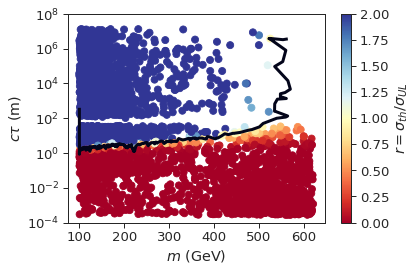

In [3]:
mHc = dataDF['mass.37']
ctau = 1.967e-16/dataDF['width.37']
r = dataDF['ExptRes.result0.r']
cm = plt.cm.get_cmap('RdYlBu')
x,y,z = mHc,ctau,r
# # Plot scatter plot (for double checking the results)
plt.figure()
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=50, cmap=cm)
cs = plt.tricontour(x,y,z,levels=[1.],linewidths=3)
# curve = cs.collections[0].get_paths()[0].vertices
# ysmooth =  savgol_filter(curve[:,1],window_length=11, polyorder=3,mode='interp') # window size 51, polynomial order 3
# plt.plot(curve[:,0],ysmooth,'--')
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e-4,1e8)
plt.tight_layout()
# plt.xlim(80,300)
plt.savefig('IDM_points_r.png',dpi=500)
plt.show()

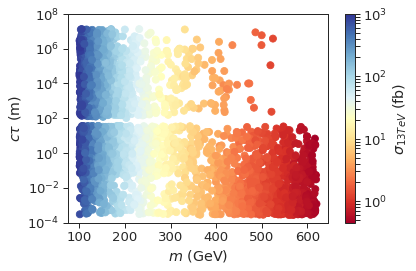

In [4]:
xsec13 = dataDF['totalxsec13TeV(fb)']
x,y,z = mHc,ctau,xsec13
# # Plot scatter plot (for double checking the results)
plt.figure()
cp = plt.scatter(x,y, c=z, vmin=z.min(), vmax=z.max(), s=50, cmap=cm, norm=LogNorm())
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
cb.set_label(r'$\sigma_{13TeV}$ (fb)')
plt.ylim(1e-4,1e8)
plt.tight_layout()
plt.savefig('IDM_totalXsec13.png',dpi=500)
plt.show()

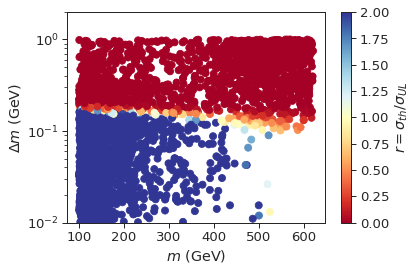

In [10]:
deltaM = (dataDF['mass.37']-dataDF['mass.35'])
mHc = dataDF['mass.37']
r = dataDF['ExptRes.result0.r']
cm = plt.cm.get_cmap('RdYlBu')
x,y,z = mHc,deltaM,r
plt.figure()
# # Plot scatter plot (for double checking the results)
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=50, cmap=cm)
# cs = plt.tricontour(x,y,z,levels=[1.],linewidths=3)
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$\Delta m$ (GeV)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e-2,2.0)
# plt.xlim(80,300)
plt.tight_layout()
plt.savefig('IDM_points_deltaM.png',dpi=500)
plt.show()

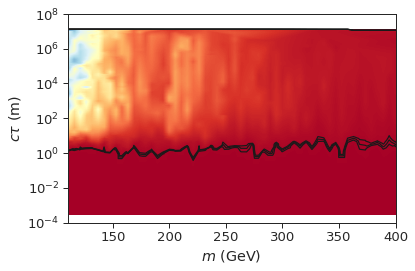

In [6]:
from scipy.interpolate import griddata
x,y,z = mHc,ctau,r

#Create a regular grid and interpolate using the original data:
newX = np.linspace(x.min(),x.max(),100)
newLogY = np.linspace(np.log10(y.min()),np.log10(y.max()),200)
newX, newLogY = np.meshgrid(newX,newLogY)

#Interpolate in log-scale:
oldLogPoints = np.array(list(zip(x,np.log10(y))))
newLogPoints = np.array([newX.flatten(),newLogY.flatten()]).T
newZ = griddata(oldLogPoints,z,newLogPoints,method='linear',fill_value=0.)

# Create the Triangulation; no triangles so Delaunay triangulation created.
newX = newLogPoints[:,0]
newY = np.power(10,newLogPoints[:,1])
triang = tri.Triangulation(newX,newY)
plt.figure()
cp = plt.tricontourf(triang, newZ,cmap=cm, levels=np.arange(0.,120.,0.2))
cs = plt.tricontour(triang, newZ, colors='k',levels=[0.8,1.0,1.2])
# # plt.clabel(cs, cs.levels, inline=True, fontsize=25, fmt='%1.1f')
# # cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
# # cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e-4,1e8)
plt.xlim(110.,400.)
plt.tight_layout()
plt.show()


In [ ]:
sns.relplot(dataDF,)

In [7]:
print(dataDF.shape)

(3951, 425)


KeyError: 'HSCP7-8'